<h2><center>Starter Code for Trees Segmentation</center></h2>

![](https://media.discordapp.net/attachments/703945836614123561/866940481263108146/banner.jpg?width=1439&height=277)

### What we are going to Learn

- Getting started Image Segmentation using PyTorch.
- Using models provided by [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) for the image segmentation.
- Training & Testing a Unet model with PyTorch

**Note : Create a copy of the notebook and use the copy for submission. Go to *File > Save a Copy in Drive* to create a new copy**

# Setting up Environment

### Downloading Dataset

So we will first need to download the python library by AIcrowd that will allow us to download the dataset by just inputting the API key. 

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 215kB 35.8MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 174kB 46.7MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.26.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
%aicrowd login

In [ ]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c tree-segmentation -o data

mkdir: cannot create directory ‘data’: File exists
train.zip:   0% 0.00/402M [00:00<?, ?B/s]
train.zip:  42% 168M/402M [00:06<00:08, 28.3MB/s]
train.zip:  92% 369M/402M [00:13<00:01, 27.8MB/s]
train.zip: 100% 402M/402M [00:14<00:00, 28.0MB/s]

test.zip:  32% 101M/316M [00:19<00:42, 5.05MB/s] 
test.zip:  42% 134M/316M [00:25<00:33, 5.43MB/s]
test.zip:  53% 168M/316M [00:30<00:26, 5.67MB/s]
test.zip:  64% 201M/316M [00:35<00:19, 6.02MB/s]
test.zip:  74% 235M/316M [00:40<00:13, 6.09MB/s]
test.zip:  85% 268M/316M [00:45<00:07, 6.60MB/s]
test.zip:  96% 302M/316M [00:51<00:02, 6.20MB/s]
test.zip: 100% 316M/316M [00:54<00:00, 5.85MB/s]


In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

replace data/train/image/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Downloading & Importing Libraries

Here we are going to use [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) which is a really popular library providing a tons of different segmentation models for pytorch including basic unets to DeepLabV3! 

Along with that, we will be also using library [pytorch-argus](https://pypi.org/project/pytorch-argus/) to help in training the model.

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch pytorch-argus

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-br0w1mje
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-br0w1mje
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 378kB 40.7MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-cp37-none-any.whl size=88684 sha256=dcb75dfaaf55601885ce6a97fb9ed695a399507df8bf875526232d9c6c797a53
  Stored in directory: /tmp/pip-ephem-wheel-cache-makriwet/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=df0d095295c8b6680328abbf922d64714ec7ffa4c943094a80173dc181b56275
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-no

In [ ]:
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
import argus
from torch.utils.data import Dataset, DataLoader

# Reading Dataset, vis and miscellaneous
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted

# Training phase ⚙️

## Creating the Dataloader

Here, we are simply create a class for pytorch to load the dataset and then to put into the model 

In [ ]:
class TreeSegmentationDataset(Dataset):
    def __init__(self, img_directory=None, label_directory=None, train=True):
        

        self.img_directory = img_directory
        self.label_directory = label_directory            

        # If the image direcotry is valid      
        if img_directory != None:
          self.img_list = natsorted(os.listdir(img_directory))
          self.label_list = natsorted(os.listdir(label_directory))

        self.train = train

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        # Reading the image
        img = Image.open(os.path.join(self.img_directory, self.img_list[idx]))


        if self.train == True:
          
          # Readiding the mak image
          mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))

          img = np.array(img, dtype=np.float32)
          mask = np.array(mask, dtype=np.float32)

          # Change image channel ordering
          img = np.moveaxis(img, -1, 0)

          return img, mask
        
        # If reading test dataset, only return image 
        else:
          
          img = np.array(img, dtype=np.float32)
          img = np.moveaxis(img, -1, 0)

          return img

In [ ]:
# Creating the training dataset
train_dataset = TreeSegmentationDataset(img_directory="data/train/image", label_directory="data/train/segmentation")
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=1, shuffle=False, drop_last=True)

In [ ]:
# Reading the image and corrosponding segmentation
image_batch, segmentation_batch = next(iter(train_loader))

image_batch.shape, segmentation_batch.shape

(torch.Size([4, 3, 512, 512]), torch.Size([4, 512, 512]))

## Visualizing Dataset

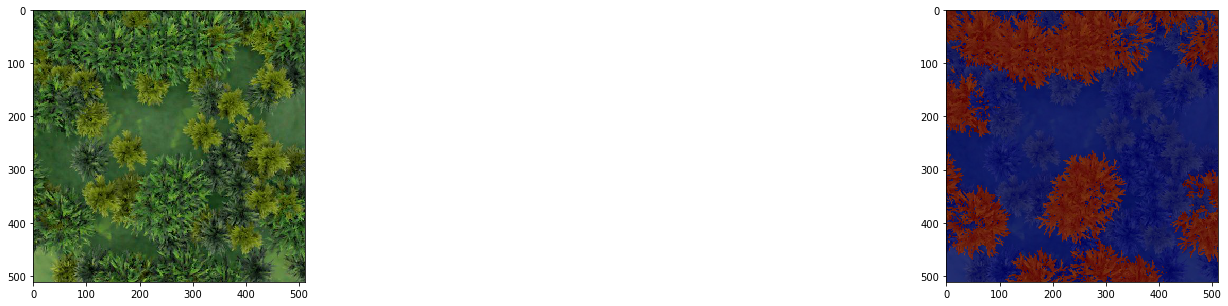

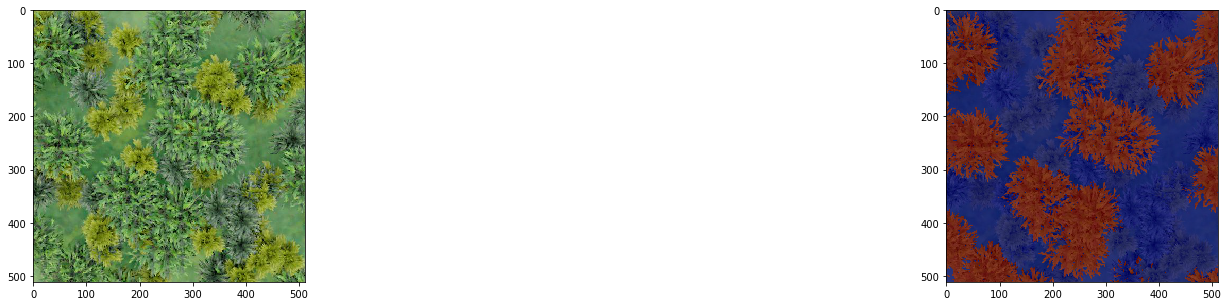

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)

# Going through each image and segmentation
for image, segmentation in zip(image_batch, segmentation_batch):

  # Change the channel ordering
  image = np.moveaxis(image.numpy()/255, 0, -1)

  # Showing the image
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(image, 'gray', interpolation='none')
  plt.subplot(1,2,2)
  plt.imshow(image, 'gray', interpolation='none')
  plt.imshow(segmentation, 'jet', interpolation='none', alpha=0.7)
  plt.show()

## Creating the Model

Here we will get setting up the model architecture, optimizer and loss.

In [ ]:
class TressSegmentationModel(argus.Model):
    nn_module = smp.Unet
    optimizer = torch.optim.Adam
    loss =  nn.MSELoss

In [ ]:
model = TressSegmentationModel({ 'device': 'cuda',
                                'nn_module': {
                                  'encoder_name': 'resnet18',
                                  'classes': 1,
                                  'in_channels': 3
                                }})
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

{'params': {'device': 'cuda', 'nn_module': {'encoder_name': 'resnet18', 'classes': 1, 'in_channels': 3}}, 'logger': <Logger argus.model.build_140100199000272 (INFO)>, 'nn_module': Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): B

## Training the Model

In [ ]:
model.fit(train_loader,
      num_epochs=1,
      metrics=['accuracy'],
      metrics_on_train=True)  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 512, 512])) that is different to the input size (torch.Size([4, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2021-07-17 16:36:01,107][INFO]: train - epoch: 0, lr: 0.001, train_loss: 16098.06, train_accuracy: 0.5976403


# Submitting Results 📄

Okay, this is the last section 😌 , let's get out testing results from the model real quick and submit our prediction directly using AIcrowd CLI

## Loading the Test Dataset

In [ ]:
test_dataset = TreeSegmentationDataset(img_directory="data/test/image", train=False)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=1, shuffle=False, drop_last=False)

## Making the Predictions

In [ ]:
predictions = []

# Ground though each test batch and adding predictions  
for images in tqdm(test_loader):
  prediction = model.predict(images)
  predictions.extend(prediction.cpu().numpy())

  0%|          | 0/1250 [00:00<?, ?it/s]

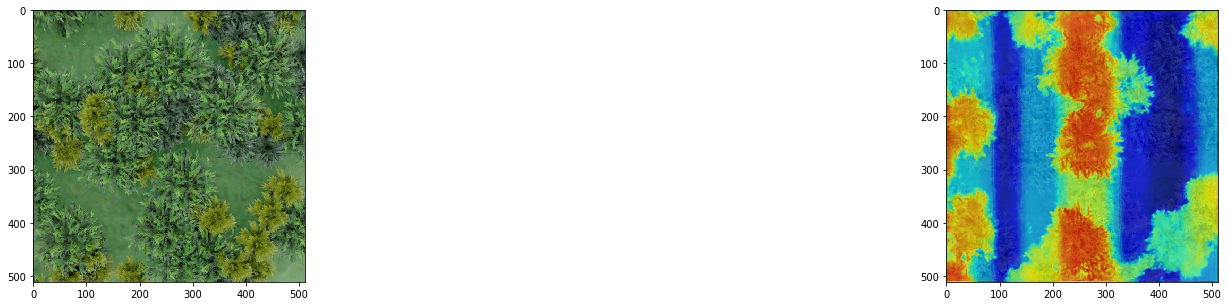

In [ ]:
# Change the channel ordering
image = np.moveaxis(images[0].numpy()/255, 0, -1)

# Showing the image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(image, 'gray', interpolation='none')
plt.imshow(predictions[-1][0], 'jet', interpolation='none', alpha=0.7)
plt.show()

In [ ]:
!rm -rf segmentation
!mkdir segmentation

for n, img in tqdm(enumerate(predictions)):

  img = img[0]

  _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

  # Making sure the pixels are only 0 and 255 in the image. 
  img = Image.fromarray(img.astype(np.uint8))

  img.save(os.path.join("segmentation", f"{n}.png"))

0it [00:00, ?it/s]


**Note : Please make sure that there should be folder `segmentation` your working directory before submitting the predictions**

## Uploading the Results

In [ ]:
!aicrowd notebook submit -c tree-segmentation -a segmentation --no-verify

Using notebook: /content/drive/MyDrive/Colab Notebooks/[Getting Started Code] Tree Segmentation using PyTorch for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...
submission.zip ━━━━━━━━━━━━━━━━━━━━ 100.0% • 428.3/428.3 MB • 3.1 MB/s • 0:00:00
                                                   ╭─────────────────────────╮                                                   
                                                   │ Successfully submitted! │                                                   
                                                   ╰─────────────────────────╯                                                   
                                                         Important links                                                         
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/cha

> Don't be shy to ask question related to any errors you are getting or doubts in any part of this notebook in [discussion forum](https://www.aicrowd.com/challenges/ai-blitz-10/problems/trees-segmentation/discussion) or in [AIcrowd Discord sever](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

Also, wanna give us your valuable feedback for next blitz or wanna work with us creating blitz challanges ? Let us know! 